In [1]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [2]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/curtailment_target_features.csv', sep = ';', index_col=0)

In [10]:
features_to_keep = ['redispatch', 'wind_speed_m/s', 'radiation_global_J/m2',
                    'air_temperature_K', 'humidity_percent',
                    'wind_gust_max_m/s', 'forecast_solar_MW',
                    'total_grid_load_MWh', 'pumped_storage_MWh']

df = df[features_to_keep]

In [11]:
# Split the entire dataset into training and test sets
cutoff_time = "2023-01-01"
train = df[df.index < cutoff_time]
test = df[df.index >= cutoff_time]
X_train = train.drop('redispatch', axis = 1)
y_train = train['redispatch']
X_test = test.drop('redispatch', axis = 1)
y_test = test['redispatch']

In [12]:
# preprocessing pipelines
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [18]:
# define number of epochs and learning rate decay
N_TRAIN = len(X_train_preprocessed)
EPOCHS = 10
BATCH_SIZE = 20
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH,
    decay_rate=1,
    staircase=False)

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

# define model
def dl_bin_class_model():
    model = tf.keras.Sequential([
        Dense(64, activation='relu', input_dim=8),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

# train model
model = dl_bin_class_model()
with tf.device('/device:GPU:0'):
  history = model.fit(X_train_preprocessed,
                    y_train_preprocessed,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/10


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [15]:
y_pred = model.predict(X_test_preprocessed)

threshold = 0.3 # counteract class imbalaance?!
y_pred_binary = (y_pred >= threshold).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_binary))

1093/1093 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.73     32472
         1.0       0.08      0.46      0.14      2484

    accuracy                           0.59     34956
   macro avg       0.51      0.53      0.43     34956
weighted avg       0.87      0.59      0.69     34956



KeyError: 'val_recall'

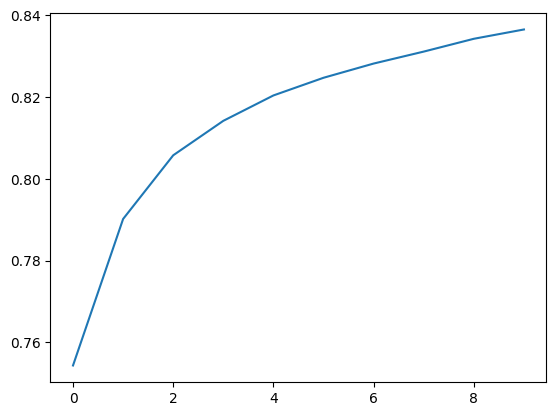

In [17]:
# plot recall
plt.plot(history.history['recall'], label='train_recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')

# plot loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')




In [ ]:
# is it overfitting?
# Batchnormalization: method to make artificial NNs faster and more stable through re-centering and re-scaling layers inputs
# Dropout: regularisation technique for reducing overfitting in ANNs by preventing complex co-adaptations on training data. Performing model averaging


In [11]:
'''
## safe
!mkdir -p saved_model
large_model.save('saved_model/my_large_model')

!zip -r saved_model.zip saved_model

# push to GitHub see [3]

## load
# unzip files
import zipfile
with zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Load the saved model
with tf.device('/device:GPU:0'):
    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')

# Check its architecture
new_large_model.summary()'''

"\n## safe \n!mkdir -p saved_model\nlarge_model.save('saved_model/my_large_model')\n\n!zip -r saved_model.zip saved_model\n\n# push to GitHub see [3]\n\n## load\n# unzip files \nimport zipfile\nwith zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:\n    zip_ref.extractall('./')\n\n# Load the saved model\nwith tf.device('/device:GPU:0'):\n    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')\n\n# Check its architecture\nnew_large_model.summary()"